# Clustering Notebook
## Main questions of interest:
<ol> 
<li>Which descriptors best predict potency?  How do we validate these?
    <ul>
    <li><strong>F-statistic</strong>; H0: There does not exist a relationship between regression parameters. Ha: There does exist a relationship between regression parameters.</li>
    <li><strong>Mixed Selection (pvalues)</strong>; Best indendent dimensions p-values in OLS.</li>
    <li><strong>Forward Selection R^2</strong>; Best mix of columns to maximize R^2.</li>
    <li><strong>Lasso</strong>; Gridsearch lambda let lasso drop dimensions, plot results.</li>
    <li><strong>PCA</strong>; Consider a PCA on all dimensions EXCLUDED from the methods above, this way we can still capture the most gain from the other dimensions if we want too instead of just dropping them.</li>
    <li>[...]</li>
    <li>[...]</li>
    </ul> 
</li>

<li>Can we augment the data set with predicted negative data (molecules expected to be inactive) to improve our machine learning models? Are there certain characteristics of negative data sets that are the most useful for training?
    <ul>
        <li>What value should IC50 be filled with (zero?)</li>
        <li>What attributes relate most to the negative data?</li>
        <li>Explore similar techniques from (1)</li>
        <li><strong>K=2</strong>; Now we know for sure there is a binary partition in the data, because we manufactured it.</li>
        <li><strong>SVM</strong>; We also know that a p-space hyperplace should classify this into two groups, making SVM a valuable option as well.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>

<li>Given the limited size of the data set and the high cost of experiments, can we use ML to identify the missing data that would be best for model training?
    <ul>
        <li><strong>KNR</strong>; What are my 5 nearest neighbors, make me interpolate me like them.</li>
        <li><strong>Bayes</strong> (Posterior Probabiliy); bin the response, Find max likelihood of me being in that bin, if I am in that bin, grab everyone else in that bin and draw a probability of me like that bins mean/std.</li>
        <li><strong>Naive Bayes</strong> (Posterior Probabiliy); same logic as bayes except independence assumption.</li>
        <li><strong>Markov Chains</strong>; DTMC or CTMC; Based on these probabilities, Assess what the steady state distribution will look like of me <em>bin</em> changing based on the training data's behavior.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>Which cluster most closely with OSM-S-106?
    <ul>
        <em>k=2; negative data set and positive dataset.</em>
        <li><strong>Heirarchical Clustering</strong>; How does our heirarchy build and classify?</li>
        <li><strong>EM Clustering</strong>; Take variance into account</li>
        <li><strong>K-means</strong>; Baseline</li>
        <li><strong>KNN</strong>; Do we have nearest neigbors from the negative data?</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>Would this provide clues as to the mechanism of OSM-S-106?
    <ul>
        <li>Mixed Selection (pvalues)</li>
        <li>Forward Selection R^2</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>How well do more advanced ML models perform over simple methods like multiple linear regression, SVM, and random forest?
    <ul>
        <li><strong>Random Forest</strong>; Gridsearch number of trees, How do these forests segment our data.</li>
        <li><strong>Adaboost</strong>; Gridsearch alpha (learning rate). Let this guy perfectly fit the data and see how it segments trees for exploratory reasons.</li>
        <li> <strong>Neural Network</strong>; Gridsearch layers. Traditionally they don't do good on this type of problem, but the black box never ceases to amaze in p-space.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul></li>
</ol>

## Import Libraries
<hr>

In [1]:
# Core
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import os
import subprocess
def install_package(name):
    sudoPassword = ''
    command = 'pip install ' + name
    p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))

# Stats
from statsmodels.regression import linear_model
import statsmodels.api as sm

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *



/Library/Python/2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Import Data
<hr>

Data provided from: https://www.dropbox.com/sh/c9mbk8e2e8jxqfy/AADSmMbdoZduyG7Eq0HwOTT_a?dl=0

### Series3_6.15.17_padel.csv
This contains the data on OSM-S-106 and other OSM compounds. The field "IC50" describes potency. Smaller IC50 corresponds to higher potency, but a value of zero is impossible. A value of >40 means that the compound lacks enough activity to be interesting to us. OSM-S-106 has IC50 = 0.036.

### *_decoys_padel.csv
8 data sets called *_decoys_padel.csv. These large data sets contain compounds predicted to have minimal or no activity (IC50 can be assigned >200?).

### Selleck_filtered_padel_corrected.csv
Selleck_filtered_padel_corrected.csv. This is a set of well-characterized drugs from a vendor. We wish to identify drugs most similar to OSM-S-106 and predicted to be potent.

In [2]:
# Read in main data
main_df = pd.read_csv("Series3_6.15.17_padel.csv")

# Read in placebos data
placebo_1 = pd.read_csv("Akt1_decoys_padel.csv")
placebo_2 = pd.read_csv("AmpC_decoys_padel.csv")
placebo_3 = pd.read_csv("cp3a4_decoys_padel.csv")
placebo_4 = pd.read_csv("cxcr4_decoys_padel.csv")
placebo_5 = pd.read_csv("HIVpr_decoys_padel.csv")
placebo_6 = pd.read_csv("HIVrt_decoys_padel.csv")
placebo_7 = pd.read_csv("Kif11_decoys_padel.csv")
#placebo_8 = pd.read_csv("Selleck_filtered_padel_corrected.csv")

# Append dumby response column.
placebo_1.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_1.shape[0])], dtype="float64"))) 
placebo_2.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_2.shape[0])], dtype="float64"))) 
placebo_3.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_3.shape[0])], dtype="float64"))) 
placebo_4.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_4.shape[0])], dtype="float64"))) 
placebo_5.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_5.shape[0])], dtype="float64"))) 
placebo_6.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_6.shape[0])], dtype="float64"))) 
placebo_7.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_7.shape[0])], dtype="float64"))) 
#placebo_8.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_8.shape[0])], dtype="float64"))) 

# Gather our dataframes for collective manipulation
frames = [main_df,   placebo_1, placebo_2, 
          placebo_3, placebo_4, placebo_5,
          placebo_6, placebo_7]

frames[0].head()

,Name,IC50,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,OSM-S-106,0.036,0,-1.0958,1.200778,23.1572,39.591930,15,17,30,...,10.200817,40.713610,2.035681,22.242022,4.765434,11.047825,799,31,0.727,110
1,OSM-S-107,10.000,0,1.1547,1.333332,38.0230,49.112481,15,16,40,...,8.202895,48.001779,2.087034,18.848454,0.000000,13.231952,1321,34,3.185,124
2,OSM-S-118,50.000,0,0.5906,0.348808,7.7935,31.554344,15,17,23,...,9.219166,31.354825,2.090322,9.306953,0.000000,6.214417,343,21,4.191,80
3,OSM-S-119,50.000,0,2.2246,4.948845,25.3114,36.320758,15,17,23,...,15.993993,35.091951,2.064232,14.383663,0.000000,6.220694,480,27,5.059,92
4,OSM-S-120,50.000,0,1.3358,1.784362,16.7123,33.937551,15,17,23,...,12.606580,33.230029,2.076877,11.846725,0.000000,6.220707,411,23,4.625,86


### Remove NAs | Concat | Clean

In [3]:
# It only makes sense to keep non-null responses.
row_mask=frames[0].isnull().any(axis=1) == False
frames[0] = frames[0].loc[row_mask,:]

# Confirm
frames[0].shape # Correct, it dropped from 70 to 46.

for f in frames[1:]:
    f=f.fillna(0)
    print(f.shape)

    
bigframe = pd.concat(frames)
print bigframe.shape
bigframe = bigframe[frames[0].columns]
bigframe.tail()

bigframe=bigframe.replace([np.inf, -np.inf, np.nan], 0)
bigframe=bigframe.apply(lambda col: col.replace("#NAME?", 0) , axis=0)
bigframe=bigframe.apply(lambda col: col.fillna(0))
print(any(bigframe.isnull().any())) # no nans..

(16450, 1446)
(2850, 1446)
(11800, 1446)
(3406, 1446)
(35750, 1446)
(18891, 1446)
(6850, 1446)
(96043, 1446)
False


## PCA | Kmeans

Lets try PCA, plot each component, then fit a regression to it and try to plot it. Heatmap by IC50. Wrap by cluster.


In [164]:
# Setup data
y=bigframe.iloc[:,1].as_matrix()
X=bigframe.iloc[:,2:].as_matrix()

# Setup algorithmic objects
pipe = Pipeline([('scaler', StandardScaler()),
                 ('kmeans', KMeans())])
scaler = StandardScaler()
kmeans = KMeans(n_clusters=2)
pca = PCA()

# Initiate scaling
X=scaler.fit_transform(X)
print("Finished scaling")

# Initiate clustering
kmeans_output = kmeans.fit(X)
kmeans_output.labels_

print("Finished kmeans")
# Initiate dim. drop (un-transformed, I.e., just eigenvalues, variance_explained, ect..)
pca_output = pca.fit(X)
pca_output.explained_variance_ #explained variance of all 70 components
components_nums = [i for i in range(len(pca_output.components_))]

# Illustrate variance cutoff.
pca_df=pd.DataFrame({'explained_variance':pca_output.explained_variance_}, index=components_nums)
pca_df.plot(title='Components vs. Variance')
plt.show()

# Illustrate dim. drop (transformed, I.e., projected onto our new basis that captured the most variance in our data)
pca_output = pca.fit_transform(X)
pca_df_dropped = pd.DataFrame(pca_output, 
                              columns=["PC_"+str(i) for i in components_nums])
pca_df_dropped = pca_df_dropped.iloc[:,0:3]
pca_df_dropped['cluster'] = pd.DataFrame(kmeans_output.labels_, columns=['cluster'], dtype='category')
pca_df_dropped['IC50'] = y
pca_df_dropped.head()

ValueError: could not convert string to float: Low

### What do the clusters look like? Do they look separable? Do we see a pattern?

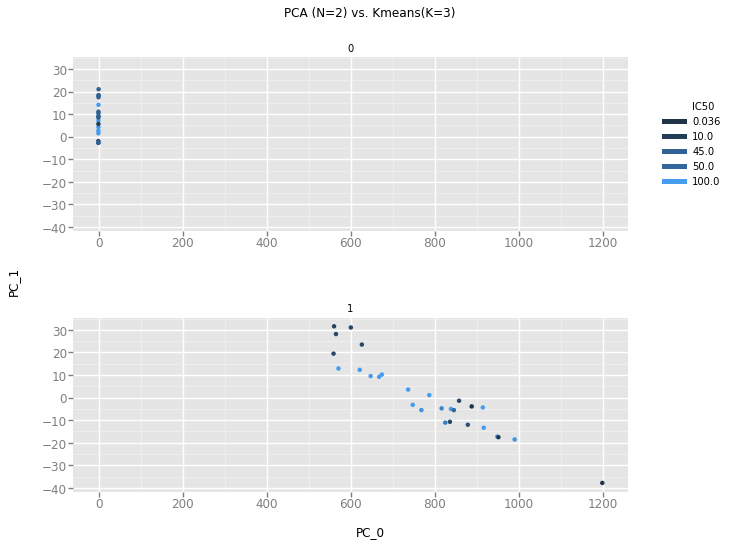

<ggplot: (278415217)>

In [11]:
p = ggplot(aes(x='PC_0', y='PC_1',z='PC_2', color='IC50'), data=pca_df_dropped )
p = p + geom_point() + facet_wrap('cluster') + ggtitle("PCA (N=2) vs. Kmeans(K=2)")
p

### Whats the best K?

From our analysis above, we can see that the data should be logically partitioned into 2 sets, compounds that are potent or not. We know that any potency less than 0.4 is potent to some degree. This is good news. So lets create a function to calculate the completeness and genuineity to define the correct number for K.



In [5]:
from __future__ import division

def categorize2(row):
    returnBin="High"
    if row > 40.0:
        returnBin="Low"
    return returnBin

def categorize3(row):
    returnBin=""
    if row > 40:
        returnBin="Low"
    elif row >10:
        returnBin="Medium"
    else:
        returnBin="High"
    return returnBin

def categorize4(row):
    v=(0.036/row)*100
    returnBin=""
    if v > 10.0:
        returnBin="High"
    elif v > 1.0:
        returnBin="MediumHigh"
    elif v > 0.1:
        returnBin="MediumLow"
    elif v > 0.01:
        returnBin="Low"
    else:
        returnBin="Other"
    return returnBin

def categorize5(row):
    v=(0.036/row)*100
    returnBin=""
    if v > 10.0:
        returnBin="High"
    elif v > 1.0:
        returnBin="MediumHigh"
    elif v > 0.3:
        returnBin="MediumAvg"
    elif v > 0.1:
        returnBin="MediumLow"
    elif v > 0.01:
        returnBin="Low"
    else:
        returnBin="Other"
    return returnBin

#bigframe.drop('bin2', axis=1, inplace=True)
#bigframe.drop('bin3', axis=1, inplace=True)
#bigframe.drop('bin4', axis=1, inplace=True)
#bigframe.drop('bin5', axis=1, inplace=True)

bigframe.insert(2, 'bin2', bigframe["IC50"].transform(categorize2).astype('category') )
bigframe.insert(3, 'bin3', bigframe["IC50"].transform(categorize3).astype('category') )
bigframe.insert(4, 'bin4', bigframe["IC50"].transform(categorize4).astype('category') )
bigframe.insert(5, 'bin5', bigframe["IC50"].transform(categorize5).astype('category') )
bigframe.head()


,Name,IC50,bin2,bin3,bin4,bin5,nAcid,ALogP,ALogp2,AMR,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,OSM-S-106,0.036,High,High,High,High,0,-1.0958,1.200778,23.1572,...,10.200817,40.713610,2.035681,22.242022,4.765434,11.047825,799.0,31.0,0.727,110.0
1,OSM-S-107,10.000,High,High,MediumLow,MediumAvg,0,1.1547,1.333332,38.0230,...,8.202895,48.001779,2.087034,18.848454,0.000000,13.231952,1321.0,34.0,3.185,124.0
2,OSM-S-118,50.000,Low,Low,Low,Low,0,0.5906,0.348808,7.7935,...,9.219166,31.354825,2.090322,9.306953,0.000000,6.214417,343.0,21.0,4.191,80.0
3,OSM-S-119,50.000,Low,Low,Low,Low,0,2.2246,4.948845,25.3114,...,15.993993,35.091951,2.064232,14.383663,0.000000,6.220694,480.0,27.0,5.059,92.0
4,OSM-S-120,50.000,Low,Low,Low,Low,0,1.3358,1.784362,16.7123,...,12.606580,33.230029,2.076877,11.846725,0.000000,6.220707,411.0,23.0,4.625,86.0


In [6]:
df_bin_counts = pd.DataFrame({'bin2':bigframe.groupby(['bin2'])["bin2"].count(),
                              'bin3':bigframe.groupby(['bin3'])["bin3"].count(),
                              'bin4':bigframe.groupby(['bin4'])["bin4"].count(),
                              'bin5':bigframe.groupby(['bin5'])['bin5'].count()})
df_bin_counts


,bin2,bin3,bin4,bin5
High,18.0,11.0,1.0,1.0
Low,96025.0,96025.0,96026.0,96026.0
Medium,NaN,7.0,NaN,NaN
MediumHigh,NaN,NaN,2.0,2.0
MediumLow,NaN,NaN,14.0,6.0
MediumAvg,NaN,NaN,NaN,8.0


In [8]:
# Setup data
ytrue2=bigframe["bin2"].as_matrix()
ytrue3=bigframe["bin3"].as_matrix()
ytrue4=bigframe["bin4"].as_matrix()
ytrue5=bigframe["bin5"].as_matrix()
y=bigframe.iloc[:,1].as_matrix()
X=bigframe.iloc[:,6:].as_matrix()

# Set up constant objects
purity_df=pd.DataFrame({'ytrue2':ytrue2,
                        'ytrue3':ytrue3,
                        'ytrue4':ytrue4,
                        'ytrue5':ytrue5})

pca = PCA()
scaler=StandardScaler()

# Initiate scaling
X=scaler.fit_transform(X)
print("Finished scaling")

In [9]:

for k in [2,3,4,5]:

    print("Number of clusters", k)
    
    # Compute KMeans
    kmeans=KMeans(n_clusters=k)

    # Initiate clustering
    kmeans_output = kmeans.fit(X)
    kmeans_output.labels_
    print("Finished KMeans")

    # Publish information to our purity score
    purity_df['KMeans_clusters_'+str(k)]=kmeans_output.labels_



('Number of clusters', 2)
Finished KMeans
Finished DBScan
('Number of clusters', 3)
Finished KMeans
Finished DBScan
('Number of clusters', 4)
Finished KMeans
Finished DBScan
('Number of clusters', 5)
Finished KMeans
Finished DBScan


In [25]:
purity_df.head()
df_score_melted.head()

,k,metric,score
0,KMeans_clusters_2,completeness_score,0.356351
1,KMeans_clusters_3,completeness_score,0.002149
2,KMeans_clusters_4,completeness_score,0.002042
3,KMeans_clusters_5,completeness_score,0.001332
4,KMeans_clusters_2,homogeneity_score,0.821489


Homogeneity: 0.821
Completeness: 0.356
V-measure: 0.497
Homogeneity: 0.768
Completeness: 0.002
V-measure: 0.004
Homogeneity: 0.775
Completeness: 0.002
V-measure: 0.004
Homogeneity: 0.737
Completeness: 0.001
V-measure: 0.003


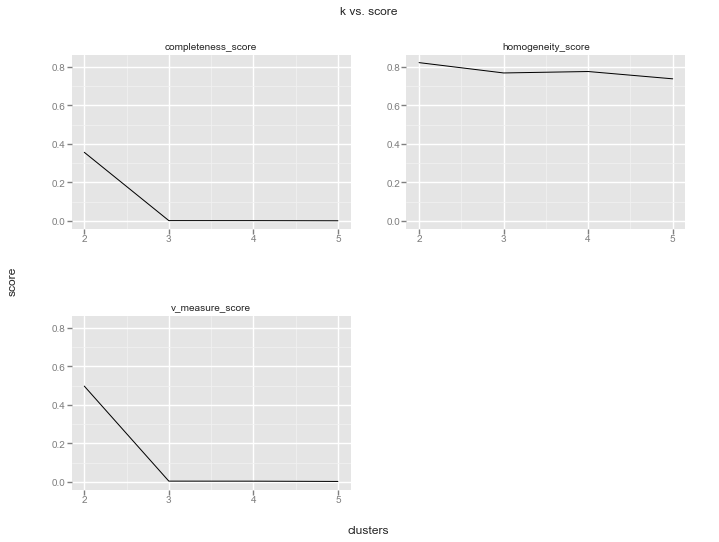

<ggplot: (295125029)>

In [50]:
homo=[]
comp=[]
vsco=[]
kval=[]
for i in range(4):
    truth=purity_df[purity_df.columns[i]]
    pred=purity_df[purity_df.columns[i+4]]
    homo_score = homogeneity_score(truth, pred)
    comp_score = completeness_score(truth, pred)
    v_score = v_measure_score(truth,pred)
    print("Homogeneity: %0.3f" % homo_score)
    print("Completeness: %0.3f" % comp_score)
    print("V-measure: %0.3f" % v_score)
    kval.append(purity_df.columns[i+4])
    vsco.append(v_score)
    comp.append(comp_score)
    homo.append(homo_score)

    
df_scores = pd.DataFrame({'homogeneity_score':homo,
                          'completeness_score':comp,
                          'v_measure_score':vsco,
                          'k':kval})
df_score = df_scores[["k","completeness_score","homogeneity_score","v_measure_score"]]
df_score.head()
df_score_melted = pd.melt(df_score, id_vars=['k'],
                          var_name='metric', value_name='score')

df_score_melted.k=df_score_melted.k.replace("KMeans_clusters_2", "2").replace("KMeans_clusters_3","3").replace("KMeans_clusters_4", "4").replace("KMeans_clusters_5","5")
p = ggplot(aes(x="k",y="score"),data=df_score_melted) + geom_line() +\
      facet_wrap('metric') +\
        ggtitle("k vs. score") + xlab("clusters")
        
p

('Number of nieghbors:', 2)


In [162]:
#pca_df_dropped.drop('cluster', axis=1, inplace=True)

pca_df_dropped['clusters_2'] = purity_df.clusters_2
pca_df_dropped['clusters_3'] = purity_df.clusters_3
pca_df_dropped['clusters_4'] = purity_df.clusters_4
pca_df_dropped['clusters_5'] = purity_df.clusters_5
pca_df_dropped_melt=pd.melt(pca_df_dropped, id_vars=["PC_0","PC_1","PC_2","IC50"],
                           var_name="cluster", value_name="assignment")
pca_df_dropped_melt.tail()

,PC_0,PC_1,PC_2,IC50,cluster,assignment
384167,-0.523624,-5.007288,4.899237,NaN,clusters_5,0
384168,-0.307706,0.804033,-10.889557,NaN,clusters_5,2
384169,-0.195950,6.070097,-14.435422,NaN,clusters_5,2
384170,-0.451826,-3.608918,-10.954710,NaN,clusters_5,2
384171,-0.363442,4.003456,-2.998079,NaN,clusters_5,2


In [163]:
bigframe["IC50"].tail()

6845    250.0
6846    250.0
6847    250.0
6848    250.0
6849    250.0
Name: IC50, dtype: float64

### Analysis

<strong>Homogenueity</strong>: A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

Clusters that include samples from different classes do not make for an homogeneous labeling:
<code>
print(completeness_score([0, 0, 1, 1], [0, 1, 0, 1]))
0.0
print(completeness_score([0, 0, 0, 0], [0, 1, 2, 3]))
0.0
</code>

<strong>Completeness</strong>: A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

If classes members are split across different clusters, the assignment cannot be complete:
<code>
print(completeness_score([0, 0, 1, 1], [0, 1, 0, 1]))
0.0
print(completeness_score([0, 0, 0, 0], [0, 1, 2, 3]))
0.0
</code>

From the <code>homogenueity_score, completeness_score, and v_measure_score</code>, we can conclude that<code> k=2 </code>provides our best cut in the data set to decide whether an object was potent or not. This will be the distinguishing factor between attribuets that are and aren't important; those on either side positively or negatively influence the attribute importance.